# Practical Assesment Task #1: Colorizing Images with Generative Adversarial Networks
Técnicas Generativas y Aprendizaje por Refuerzo - Curso 2024/2025


## Import Dependencies and Set General Parameters

In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import keras
import matplotlib.axes
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
from pathlib import Path

from keras.layers import (
    Activation, BatchNormalization, MaxPooling2D,
    Conv2D, Dense, Dropout, Flatten, LeakyReLU, Conv2DTranspose, 
    Input, concatenate
)
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.datasets import cifar10
from keras.models import Sequential, Model

print("TF version:", tf.__version__)
print(tf.config.list_physical_devices('GPU'))
# Enable memory growth for GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

IMAGE_SIZE = 32
BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 100

WORKDIR = "results_p2/GAN"

# Create directories
Path(WORKDIR).mkdir(parents=True, exist_ok=True)

TF version: 2.9.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Define Dataset Loader

In [2]:
def generate_dataset(images: list, debug=False) -> tuple[np.ndarray, np.ndarray]:
    """
    This function converts a list of RGB images to the LAB color space, and separates the L channel from the A and B channels.
    The images are normalized and reshaped to the appropriate dimensions for the model.

    Parameters:
    images (list): A list of RGB images
    debug (bool): If True, the function will display the original and converted images

    Returns:
    X (np.array): A numpy array of L channels of the images
    Y (np.array): A numpy array of A and B channels of the images
    """
    X = []
    Y = []

    for i in images:
        lab_image_array = rgb2lab(i / 255)  # Convert the image from RGB to LAB color space
        x = lab_image_array[:, :, 0]  # Get the L channel
        y = lab_image_array[:, :, 1:]  # Get the A and B channels
        y /= 128  # normalize

        if debug:  # If debug is True, display the original and converted images
            fig = plt.figure()
            fig.add_subplot(1, 2, 1)
            plt.imshow(i / 255)

            fig.add_subplot(1, 2, 2)
            plt.imshow(lab2rgb(np.dstack((x, y * 128))))
            plt.show()

        X.append(x.reshape(IMAGE_SIZE, IMAGE_SIZE, 1))  # Reshape the L channel and append to the list
        Y.append(y)  # Append the A and B channels to the list

    X = np.array(X, dtype=np.float32)  # Convert the list to a numpy array
    Y = np.array(Y, dtype=np.float32)  # Convert the list to a numpy array

    return X, Y

def load_data(force=False) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    This function loads the CIFAR-10 dataset, processes it, and saves/loads the processed data to/from the disk.

    Parameters:
    force (bool): If True, the function will reprocess the data even if it already exists on the disk

    Returns:
    X_train, Y_train, X_test, Y_test (np.array): Numpy arrays of the training and testing data
    """
    is_saved_arrays_exist = os.path.isfile(os.path.join(WORKDIR, 'X_train.npy'))  # Check if the processed data already exists on the disk

    if not is_saved_arrays_exist or force:  # If the processed data does not exist or if force is True, process the data
        (train_images, _), (test_images, _) = cifar10.load_data()  # Load the CIFAR-10 dataset
        X_train, Y_train = generate_dataset(train_images, debug=False)  # Process the training images
        X_test, Y_test = generate_dataset(test_images, debug=False)  # Process the testing images
        print('Saving processed data')
        np.save(os.path.join(WORKDIR, 'X_train.npy'), X_train)  # Save the processed training data to the disk
        np.save(os.path.join(WORKDIR, 'Y_train.npy'), Y_train)  # Save the processed training data to the disk
        np.save(os.path.join(WORKDIR, 'X_test.npy'), X_test)  # Save the processed testing data to the disk
        np.save(os.path.join(WORKDIR, 'Y_test.npy'), Y_test)  # Save the processed testing data to the disk
    else:  # If the processed data exists and force is False, load the data from the disk
        print('Loading processed data')
        X_train = np.load(os.path.join(WORKDIR, 'X_train.npy'))  # Load the processed training data from the disk
        Y_train = np.load(os.path.join(WORKDIR, 'Y_train.npy'))  # Load the processed training data from the disk
        X_test = np.load(os.path.join(WORKDIR, 'X_test.npy'))  # Load the processed testing data from the disk
        Y_test = np.load(os.path.join(WORKDIR, 'Y_test.npy'))  # Load the processed testing data from the disk

    return X_train, Y_train, X_test, Y_test

## Load Dataset

In [3]:
start = time.time()
# Load the processed training and testing data
X_train, Y_train, X_test, Y_test = load_data()

# Create TensorFlow datasets from the training and testing data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

# Shuffle the training dataset and batch both datasets
# SHUFFLE_BUFFER_SIZE determines the randomness of the shuffling
# BATCH_SIZE determines the number of samples that will be propagated through the network at once
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo dataset: {int(minutos)} minutos y {segundos:.2f} segundos*******")

Loading processed data
*******Tiempo dataset: 0 minutos y 0.90 segundos*******


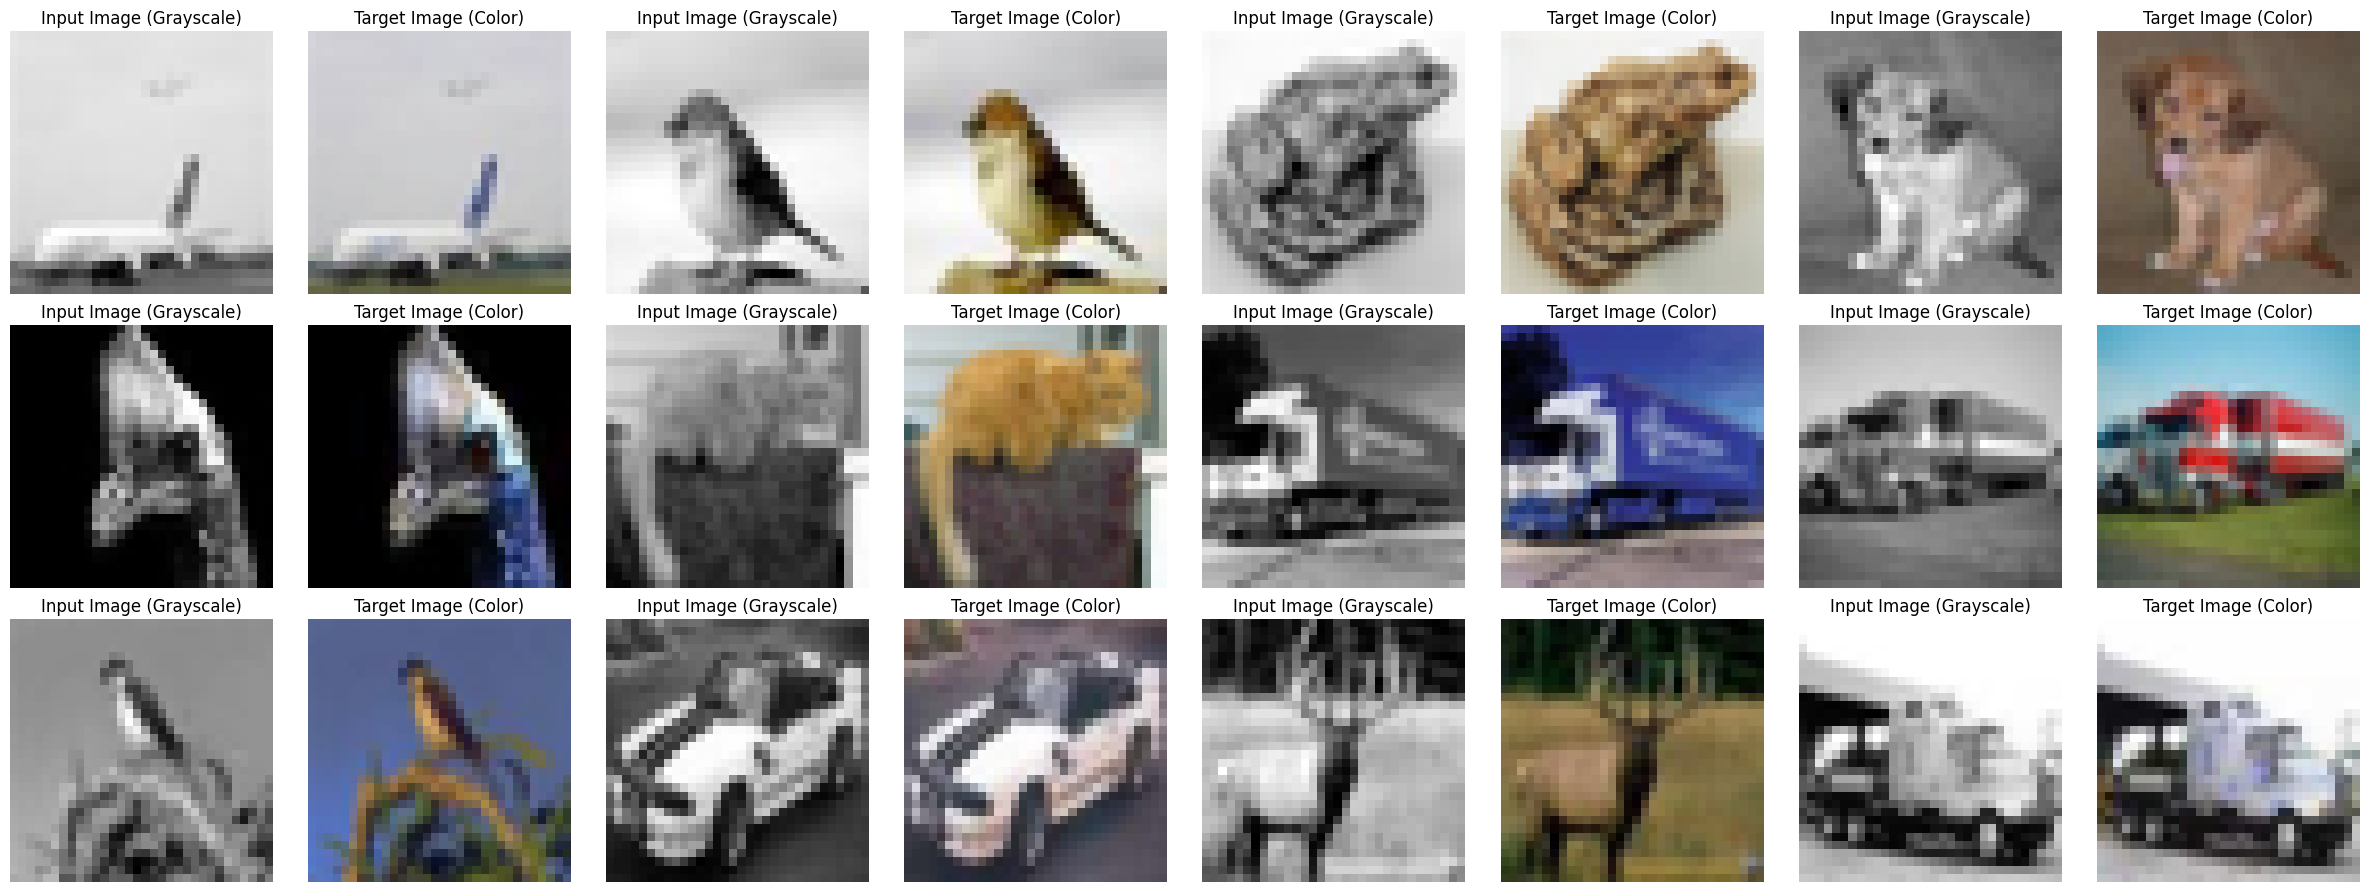

In [4]:
def show_images_from_dataset(dataset: tf.data.Dataset, num_images: int):
    count = 0
    images_per_row = 4
    num_rows = (num_images + images_per_row - 1) // images_per_row
    plt.figure(figsize=(6 * images_per_row, 3 * num_rows))
    
    for input_batch, target_batch in dataset.take(num_images):
        for i in range(num_images):
            first_input_image = input_batch[i]
            first_target = target_batch[i]

            row = i // images_per_row
            col = (i % images_per_row) * 2

            plt.subplot(num_rows, images_per_row * 2, row * images_per_row * 2 + col + 1)
            plt.imshow(first_input_image.numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
            plt.title('Input Image (Grayscale)')
            plt.axis('off')

            # Convert the LAB image to RGB for visualization
            first_target_lab = np.dstack((first_input_image.numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), first_target.numpy() * 128))
            first_target_rgb = lab2rgb(first_target_lab)

            plt.subplot(num_rows, images_per_row * 2, row * images_per_row * 2 + col + 2)
            plt.imshow(first_target_rgb)
            plt.title('Target Image (Color)')
            plt.axis('off')
        
        count += 1
        if count >= num_images:
            break

    plt.tight_layout()
    plt.savefig(os.path.join(f"{WORKDIR}/..", 'GAN_img_examples.png'))
    plt.show()

show_images_from_dataset(train_dataset, num_images=12)

## Define Generator Model

In [5]:
def build_generator_model():
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
    x = input_tensor

    # Capas de Downsampling (Encoder)
    down1 = Conv2D(32, (3, 3), strides=2, padding='same')(x)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)  # 16x16x32
    x = down1

    down2 = Conv2D(64, (3, 3), strides=2, padding='same')(x)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)  # 8x8x64
    x = down2

    down3 = Conv2D(128, (3, 3), strides=2, padding='same')(x)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)  # 4x4x128
    x = down3

    down4 = Conv2D(256, (3, 3), strides=2, padding='same')(x)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)  # 2x2x256
    x = down4

    down5 = Conv2D(512, (3, 3), strides=2, padding='same')(x)
    down5 = BatchNormalization()(down5)
    down5 = Activation('relu')(down5)  # 1x1x512
    x = down5

    # Capas de Upsampling (Decoder)
    up1 = Conv2DTranspose(512, (3, 3), strides=2, padding='same')(x)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)  # 2x2x512
    up1 = concatenate([up1, down4])  # Conexión de salto
    x = up1

    up2 = Conv2DTranspose(256, (3, 3), strides=2, padding='same')(x)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)  # 4x4x256
    up2 = concatenate([up2, down3])  # Conexión de salto
    x = up2

    up3 = Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)  # 8x8x128
    up3 = concatenate([up3, down2])  # Conexión de salto
    x = up3

    up4 = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)  # 16x16x64
    up4 = concatenate([up4, down1])  # Conexión de salto
    x = up4

    up5 = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x)
    up5 = BatchNormalization()(up5)
    up5 = Activation('relu')(up5)  # 32x32x32
    x = up5

    # Capa de salida
    output_tensor = Conv2D(2, (3, 3), padding='same', activation='tanh')(x)  # 32x32x2

    model = Model(input_tensor, output_tensor, name="Generator_Model")
    return model

## Define Discriminator Model

In [6]:
def build_discriminator_model():
    model = Sequential(name="Discriminator_Model")

    # Capa de entrada
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 2)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(MaxPooling2D((2, 2))) 
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(MaxPooling2D((2, 2))) 
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(MaxPooling2D((2, 2))) 
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid')) # Capa de salida

    return model

## Define Generator and Discriminator Loss Functions

In [7]:
# Define the weight of the GAN loss
gan_loss_weight = 0.5

# Define the regularization parameter for the generator's L2 loss
l2_lambda = 150 

# Define the loss function for the discriminator
# Binary Cross Entropy is used as the loss function since we are dealing with a binary classification problem (real vs fake images)
cross_entropy = BinaryCrossentropy() 

def discriminator_loss(disc_real_output: tf.Tensor, disc_generated_output: tf.Tensor) -> tf.Tensor:
    """
    This function calculates the total loss for the discriminator.

    Parameters:
    disc_real_output (Tensor): The discriminator's prediction on the real images
    disc_generated_output (Tensor): The discriminator's prediction on the generated (fake) images

    Returns:
    total_disc_loss (Tensor): The total loss for the discriminator
    """
    
    total_disc_loss = 0  # Initialize the total loss for the discriminator
    
    # Calculate the cross entropy loss for the real images
    real_loss = cross_entropy(tf.ones_like(disc_real_output), disc_real_output)
    
    # Calculate the cross entropy loss for the generated (synthetic) images
    generated_loss = cross_entropy(tf.zeros_like(disc_generated_output), disc_generated_output)

    # Calculate the total loss for the discriminator by adding the losses for the real and generated images
    total_disc_loss = real_loss + generated_loss
    
    # Return the total loss for the discriminator
    return total_disc_loss


def generator_loss(disc_generated_output: tf.Tensor, gen_output: tf.Tensor, target: tf.Tensor) -> tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
    """
    This function calculates the total loss for the generator.

    Parameters:
    disc_generated_output (Tensor): The discriminator's prediction on the generated (fake) images
    gen_output (Tensor): The generated (fake) images
    target (Tensor): The real images

    Returns:
    gan_loss (Tensor): The GAN loss for the generator
    l2_loss (Tensor): The L2 loss for the generator
    total_gen_loss (Tensor): The total loss for the generator
    """
    
    gan_loss = 0  # Initialize the GAN loss for the generator
    l2_loss = 0  # Initialize the L2 loss for the generator
    total_gen_loss = 0  # Initialize the total loss for the generator
    
    # Calculate the GAN loss for the generator (i.e., the loss for fooling the discriminator)
    gan_loss = cross_entropy(tf.ones_like(disc_generated_output), disc_generated_output)

    # Calculate the L2 loss for the generator by comparing the generated images to the real images
    l2_loss = tf.reduce_mean(tf.square(target - gen_output))
    
    # Calculate the total loss for the generator by adding the GAN loss (multiplied by its corresponding weight) and the L2 loss (multiplied by the regularization parameter)
    total_gen_loss = gan_loss * gan_loss_weight + l2_loss * l2_lambda 
    
    # Return the total loss, GAN loss, and L2 loss for the generator
    return total_gen_loss, gan_loss, l2_loss

## Build Generator and Discriminator Models

In [8]:
generator = build_generator_model()
discriminator = build_discriminator_model()

generator.summary()
discriminator.summary()

# Define the optimizers for the generator and discriminator
# Adam optimizer is used with a learning rate of 2e-4 and beta_1 (the exponential decay rate for the first moment estimates) of 0.5
# It is recommended to experiment with different values for the learning rate. Beta_1 value of 0.5 is recommended for GANs
# It is possible that the optimal learning rate for the generator and discriminator is different from each other
gen_learning_rate = 2e-4
gen_beta_1 = 0.5

disc_learning_rate = 2e-4
disc_beta_1 = 0.5

generator_optimizer = Adam(gen_learning_rate, beta_1=gen_beta_1)
discriminator_optimizer = Adam(disc_learning_rate, beta_1=disc_beta_1)

# Define the directory for storing the training checkpoints
checkpoint_dir = os.path.join(WORKDIR, 'training-checkpoints')
# Define the prefix for the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# Create a checkpoint object which will be used to save and load the models and optimizers
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
# Create a manager for the checkpoint object, which will be responsible for saving and loading the checkpoints
# max_to_keep parameter is set to 3, meaning that only the 3 most recent checkpoints will be kept
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

Model: "Generator_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 16, 16, 32)   0           ['batch_normalizati

In [9]:
@tf.function
def train_step(input_image: tf.Tensor, target: tf.Tensor, epoch: int) -> tuple[tf.Tensor, tf.Tensor]:
    """
    This function performs one training step for the generator and discriminator.

    Parameters:
    input_image (Tensor): The input image
    target (Tensor): The target image
    epoch (int): The current epoch number

    Returns:
    gen_total_loss (Tensor): The total loss for the generator
    disc_loss (Tensor): The loss for the discriminator
    """
    
    # Open a GradientTape context for automatic differentiation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_total_loss = 0  # Initialize the total loss for the generator
        gen_gan_loss = 0  # Initialize the GAN loss for the generator
        gen_l2_loss = 0  # Initialize the L2 loss for the generator
        disc_loss = 0  # Initialize the loss for the discriminator
        
        # Generate an image using the generator
        # (remember to set training=True, since during training time BatchNormalization layers are applied using the batch mean and variance)
        gen_output = generator(input_image, training=True)

        # Get the discriminator's predictions on the real and generated images
        # (remember to set training=True, since during training time BatchNormalization layers are applied using the batch mean and variance)
        disc_real_output = discriminator(target, training=True)
        disc_generated_output = discriminator(gen_output, training=True)

        # Calculate the losses for the generator and discriminator
        # Use the discriminator_loss() and generator_loss() functions to calculate the losses
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        gen_total_loss, gen_gan_loss, gen_l2_loss = generator_loss(disc_generated_output, gen_output, target)

    # Calculate the gradients of the generator's and discriminator's losses with respect to the trainable variables of each model
    # Use the gradient() method of the GradientTape object of each model to calculate the gradients of the losses with respect to the trainable variables of the corresponding model
    # Model's trainable variables can be accessed using the trainable_variables attribute
    gen_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply the gradients to the model's trainable variables
    # Use the apply_gradients() method of the optimizer object to apply the gradients
    # The apply_gradients() method takes a list of (gradient, variable) pairs
    # zip() function can be used to iterate over two lists simultaneously (i.e., the gradients and the model's trainable variables)
    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return gen_total_loss, disc_loss

In [10]:
# The checkpoint manager will load the latest checkpoint if it exists
# This will be used to resume training if the training process was interrupted
# If no checkpoint exists, the models will be initialized from scratch

# Restore the latest checkpoint using the checkpoint manager
checkpoint.restore(manager.latest_checkpoint)

# If a checkpoint was found and restored, print a message indicating the checkpoint file
if manager.latest_checkpoint:
    print('Restored from {}'.format(manager.latest_checkpoint))
    
# If no checkpoint was found, print a message indicating that the models are being initialized from scratch
else:
    print('Initializing from scratch')

Initializing from scratch


In [11]:
EPOCHS = 350
epoch_trace = 25
gen_loss_history = []
disc_loss_history = []

total_time = time.time()
for epoch in range(EPOCHS):
    # Record the start time of the epoch
    epoch_time = time.time()
    
    gen_loss_total = 0  # Initialize the total loss for the generator
    disc_loss_total = 0  # Initialize the total loss for the discriminator
    
    # for input_batch, target_batch in tqdm(train_dataset):
    for input_batch, target_batch in train_dataset:
        gen_loss, disc_loss = train_step(input_batch, target_batch, epoch)
        gen_loss_total += gen_loss
        disc_loss_total += disc_loss

    gen_loss_history.append(gen_loss_total / BATCH_SIZE)
    disc_loss_history.append(disc_loss_total / BATCH_SIZE)

    time_taken = time.time() - epoch_time
    if epoch % epoch_trace == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
        print(f'Epoch {epoch}: gen loss: {gen_loss_total / BATCH_SIZE}, disc loss: {disc_loss_total / BATCH_SIZE}, time: {time_taken:.2f}s')

minutos, segundos = divmod(time.time()-total_time, 60)
print(f"*******Tiempo entrenamiento: {int(minutos)} minutos y {segundos:.2f} segundos*******")

Epoch 0: gen loss: 5.055962562561035, disc loss: 0.2990434169769287, time: 19.01s
Epoch 25: gen loss: 1.538219690322876, disc loss: 0.7486196160316467, time: 7.60s
Epoch 50: gen loss: 1.2295992374420166, disc loss: 0.7760065793991089, time: 7.66s
Epoch 75: gen loss: 1.0417826175689697, disc loss: 0.8061285614967346, time: 7.69s
Epoch 100: gen loss: 0.9800808429718018, disc loss: 0.788760781288147, time: 7.71s
Epoch 125: gen loss: 0.9777083992958069, disc loss: 0.7645856142044067, time: 7.66s
Epoch 150: gen loss: 0.9374678134918213, disc loss: 0.7617968320846558, time: 7.69s
Epoch 175: gen loss: 0.9491357207298279, disc loss: 0.7491171956062317, time: 7.72s
Epoch 200: gen loss: 0.9325230121612549, disc loss: 0.7513747215270996, time: 7.74s
Epoch 225: gen loss: 0.9403615593910217, disc loss: 0.7341806292533875, time: 9.60s
Epoch 250: gen loss: 0.9319034814834595, disc loss: 0.7290801405906677, time: 7.71s
Epoch 275: gen loss: 0.9087076187133789, disc loss: 0.7380020022392273, time: 7.75s

## Losses History

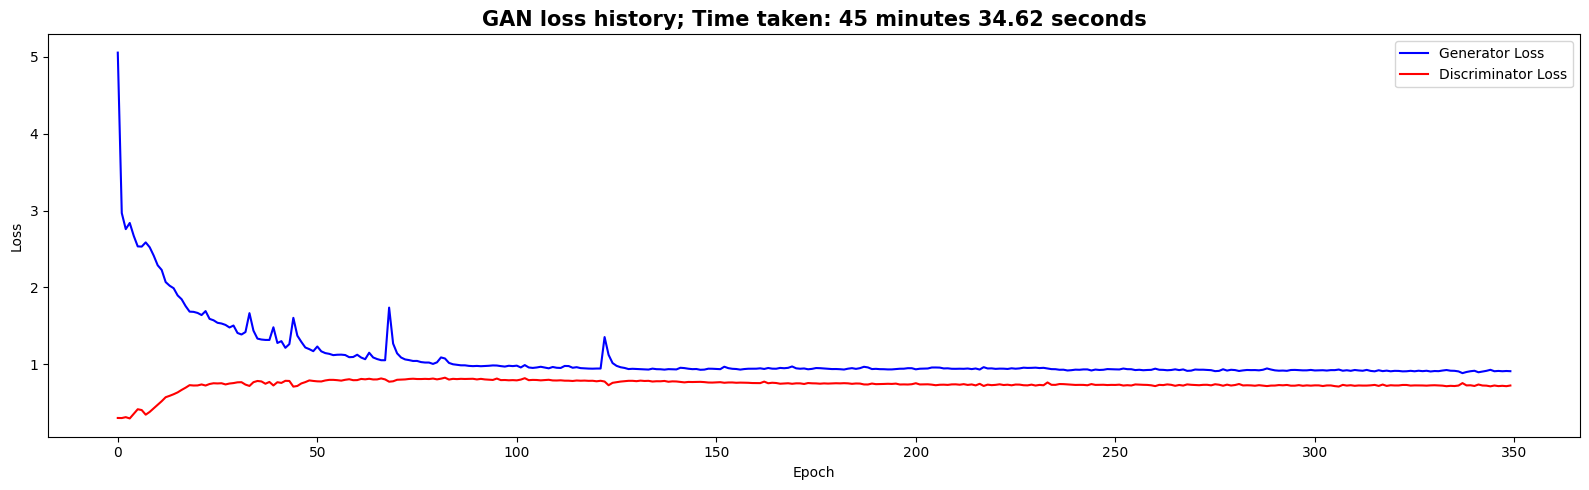

In [12]:
def plot_loss(gen_loss: list[float], disc_loss: list[float]) -> None:
    plt.figure(figsize=(16, 5))
    plt.plot(gen_loss, label='Generator Loss', color='blue')
    plt.plot(disc_loss, label='Discriminator Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'GAN loss history; Time taken: {int(minutos)} minutes {segundos:.2f} seconds', fontsize=15, fontweight='bold')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(f"{WORKDIR}/..", f'GAN_{EPOCHS}_loss_history.png'))
    plt.show()

plot_loss(gen_loss_history, disc_loss_history)

## Plot Results

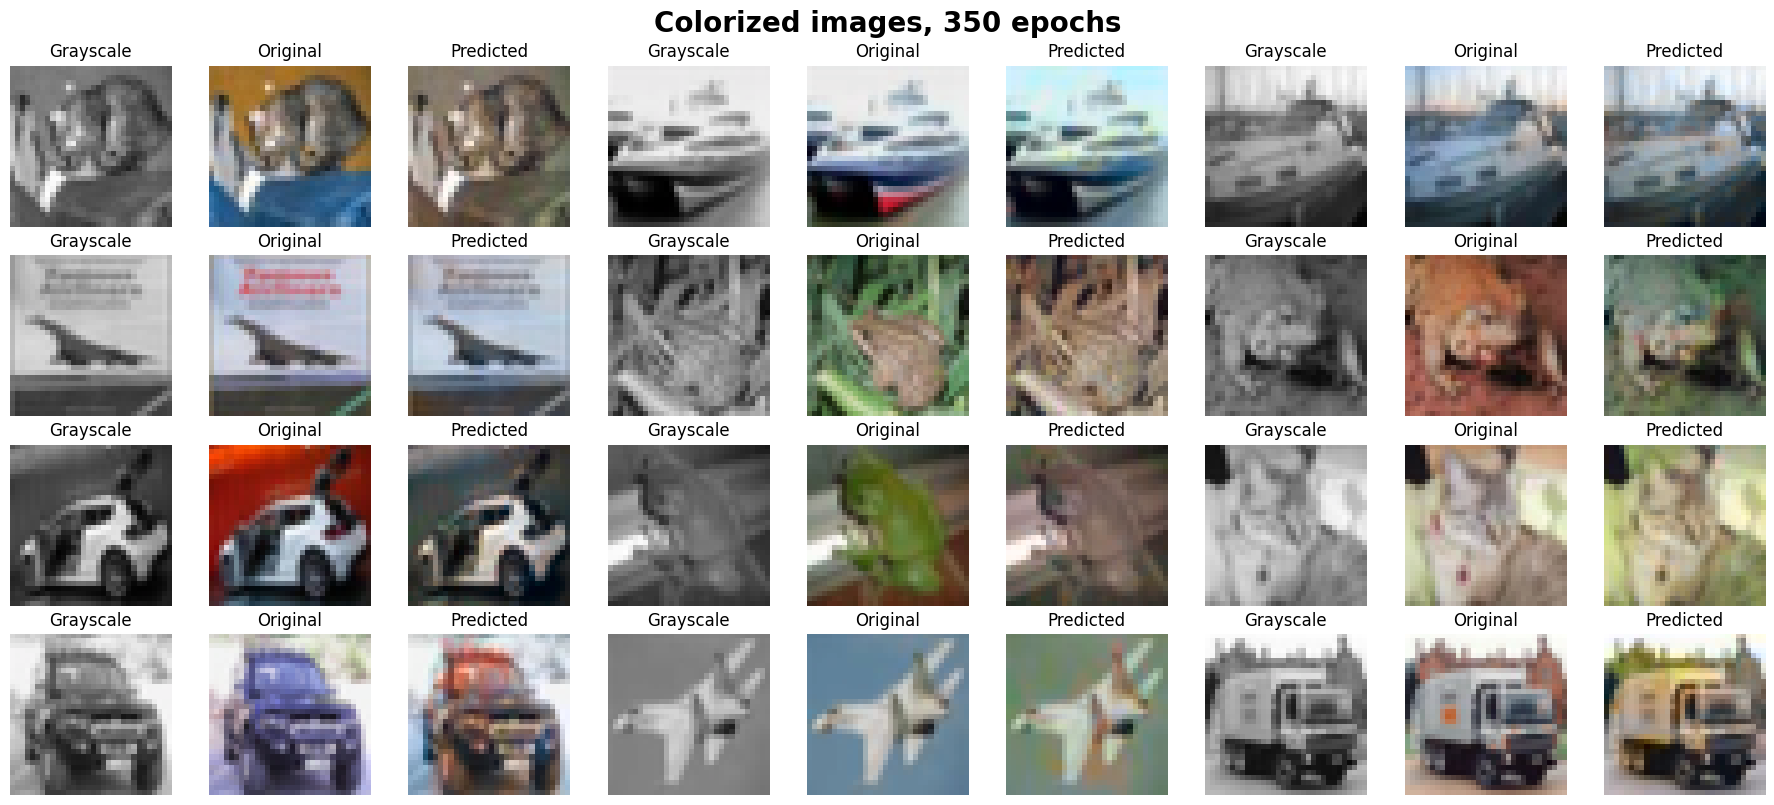

In [13]:
def plot_colorized_images(n_samples: int) -> None:
    # Generate colorized versions of the first n_samples grayscale images in the test set
    Y_hat = generator(X_test[:n_samples])

    num_cols = 9  # Number of columns in the grid (3 triplets per row)
    num_rows = (n_samples + 2) // 3  # Number of rows in the grid
    font_size = 12  # Font size for titles

    # Create a grid of subplots with num_rows rows and num_cols columns
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)  # Adjust spacing between subplots

    # Loop over the grayscale images, original color images, and colorized images
    for i, (x, y, y_hat) in enumerate(zip(X_test[:n_samples], Y_test[:n_samples], Y_hat)):
        row = i // 3
        col = (i % 3) * 3

        # Convert the original color image from Lab to RGB
        orig_lab = np.dstack((x, y * 128))
        orig_rgb = lab2rgb(orig_lab)

        # Convert the grayscale image from Lab to RGB
        grayscale_lab = np.dstack((x, np.zeros((IMAGE_SIZE, IMAGE_SIZE, 2))))
        grayscale_rgb = lab2rgb(grayscale_lab)

        # Convert the colorized image from Lab to RGB
        predicted_lab = np.dstack((x, y_hat * 128))
        predicted_rgb = lab2rgb(predicted_lab)

        # Display the grayscale image in the first column of the current row
        ax: matplotlib.axes.Axes = axes[row, col]  # Get the appropriate axis for the current subplot
        ax.axis('off')
        ax.imshow(grayscale_rgb)
        ax.set_title('Grayscale', fontsize=font_size)

        # Display the original color image in the second column of the current row
        ax = axes[row, col + 1]  # Move to the next column for original RGB
        ax.axis('off')
        ax.imshow(orig_rgb)
        ax.set_title('Original', fontsize=font_size)

        # Display the colorized image in the third column of the current row
        ax = axes[row, col + 2]  # Move to the next column for predicted colorized image
        ax.axis('off')
        ax.imshow(predicted_rgb)
        ax.set_title('Predicted', fontsize=font_size)

    # Hide empty subplots if any
    for ax_row in axes:
        for ax in ax_row:
            if not ax.has_data():
                ax.axis('off')

    plt.suptitle(f'Colorized images, {EPOCHS} epochs', fontsize=20, fontweight='bold', y=0.99)
    plt.tight_layout(pad=0.5)
    plt.savefig(os.path.join(f"{WORKDIR}/..", f'GAN_{EPOCHS}_predictions.png'))
    plt.show()

plot_colorized_images(n_samples=12)

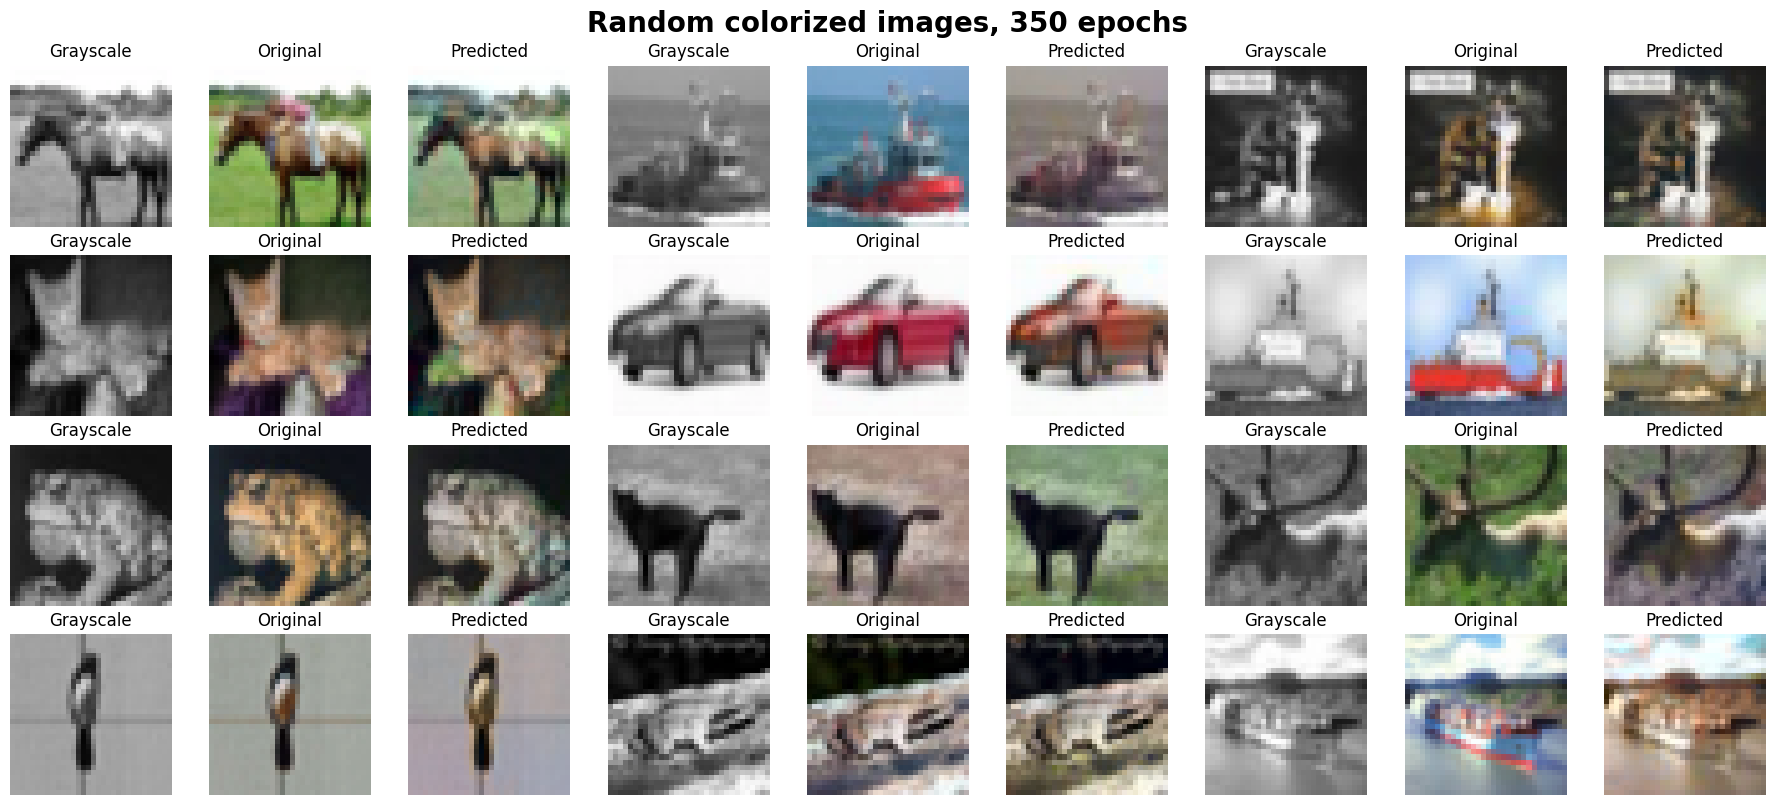

In [16]:
def plot_colorized_images_random(n_samples: int, index: int, show_figure: bool) -> None:
    indices = np.random.choice(len(X_test), n_samples, replace=False)
    
    # Generate colorized versions of the randomly selected grayscale images in the test set
    Y_hat = generator(X_test[indices])

    num_cols = 9  # Number of columns in the grid (3 triplets per row)
    num_rows = (n_samples + 2) // 3  # Number of rows in the grid
    font_size = 12  # Font size for titles

    # Create a grid of subplots with num_rows rows and num_cols columns
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)  # Adjust spacing between subplots

    # Loop over the grayscale images, original color images, and colorized images
    for i, (x, y, y_hat) in enumerate(zip(X_test[indices], Y_test[indices], Y_hat)):
        row = i // 3
        col = (i % 3) * 3

        # Convert the original color image from Lab to RGB
        orig_lab = np.dstack((x, y * 128))
        orig_rgb = lab2rgb(orig_lab)

        # Convert the grayscale image from Lab to RGB
        grayscale_lab = np.dstack((x, np.zeros((IMAGE_SIZE, IMAGE_SIZE, 2))))
        grayscale_rgb = lab2rgb(grayscale_lab)

        # Convert the colorized image from Lab to RGB
        predicted_lab = np.dstack((x, y_hat * 128))
        predicted_rgb = lab2rgb(predicted_lab)

        # Display the grayscale image in the first column of the current row
        ax: matplotlib.axes.Axes = axes[row, col]  # Get the appropriate axis for the current subplot
        ax.axis('off')
        ax.imshow(grayscale_rgb)
        ax.set_title('Grayscale', fontsize=font_size)

        # Display the original color image in the second column of the current row
        ax = axes[row, col + 1]  # Move to the next column for original RGB
        ax.axis('off')
        ax.imshow(orig_rgb)
        ax.set_title('Original', fontsize=font_size)

        # Display the colorized image in the third column of the current row
        ax = axes[row, col + 2]  # Move to the next column for predicted colorized image
        ax.axis('off')
        ax.imshow(predicted_rgb)
        ax.set_title('Predicted', fontsize=font_size)

    # Hide empty subplots if any
    for ax_row in axes:
        for ax in ax_row:
            if not ax.has_data():
                ax.axis('off')

    plt.suptitle(f'Random colorized images, {EPOCHS} epochs', fontsize=20, fontweight='bold', y=0.99)
    plt.tight_layout(pad=0.5)
    plt.savefig(os.path.join(f"{WORKDIR}/..", f'GAN_{EPOCHS}_predictions_random_{index}.png'))
    if show_figure:
        plt.show()
    plt.close()
# -----------------------------------------------------
num_batches = 5
for i in range(1, num_batches+1): # 5 batches of 12 images each
    if i < num_batches:
        plot_colorized_images_random(n_samples=12, index=i, show_figure=False)
    else:
        plot_colorized_images_random(n_samples=12, index=i, show_figure=True)

## Save the Generator and Discriminator Trained Models

In [16]:
# Save the checkpoints of the models and optimizers so that they can be loaded later
# Save the generator model in the SavedModel format
tf.saved_model.save(generator, os.path.join(WORKDIR, "generator-saved-model"))

# Save the discriminator model in the SavedModel format
tf.saved_model.save(discriminator, os.path.join(WORKDIR, "discriminator-saved-model"))

INFO:tensorflow:Assets written to: results_p2\generator-saved-model\assets


INFO:tensorflow:Assets written to: results_p2\generator-saved-model\assets


INFO:tensorflow:Assets written to: results_p2\discriminator-saved-model\assets


INFO:tensorflow:Assets written to: results_p2\discriminator-saved-model\assets


## Load saved models

In [ ]:
import tensorflow as tf
import os

test_generator = tf.saved_model.load("results_p2/GAN/generator-saved-model")
test_discriminator = tf.saved_model.load("results_p2/GAN/discriminator-saved-model")

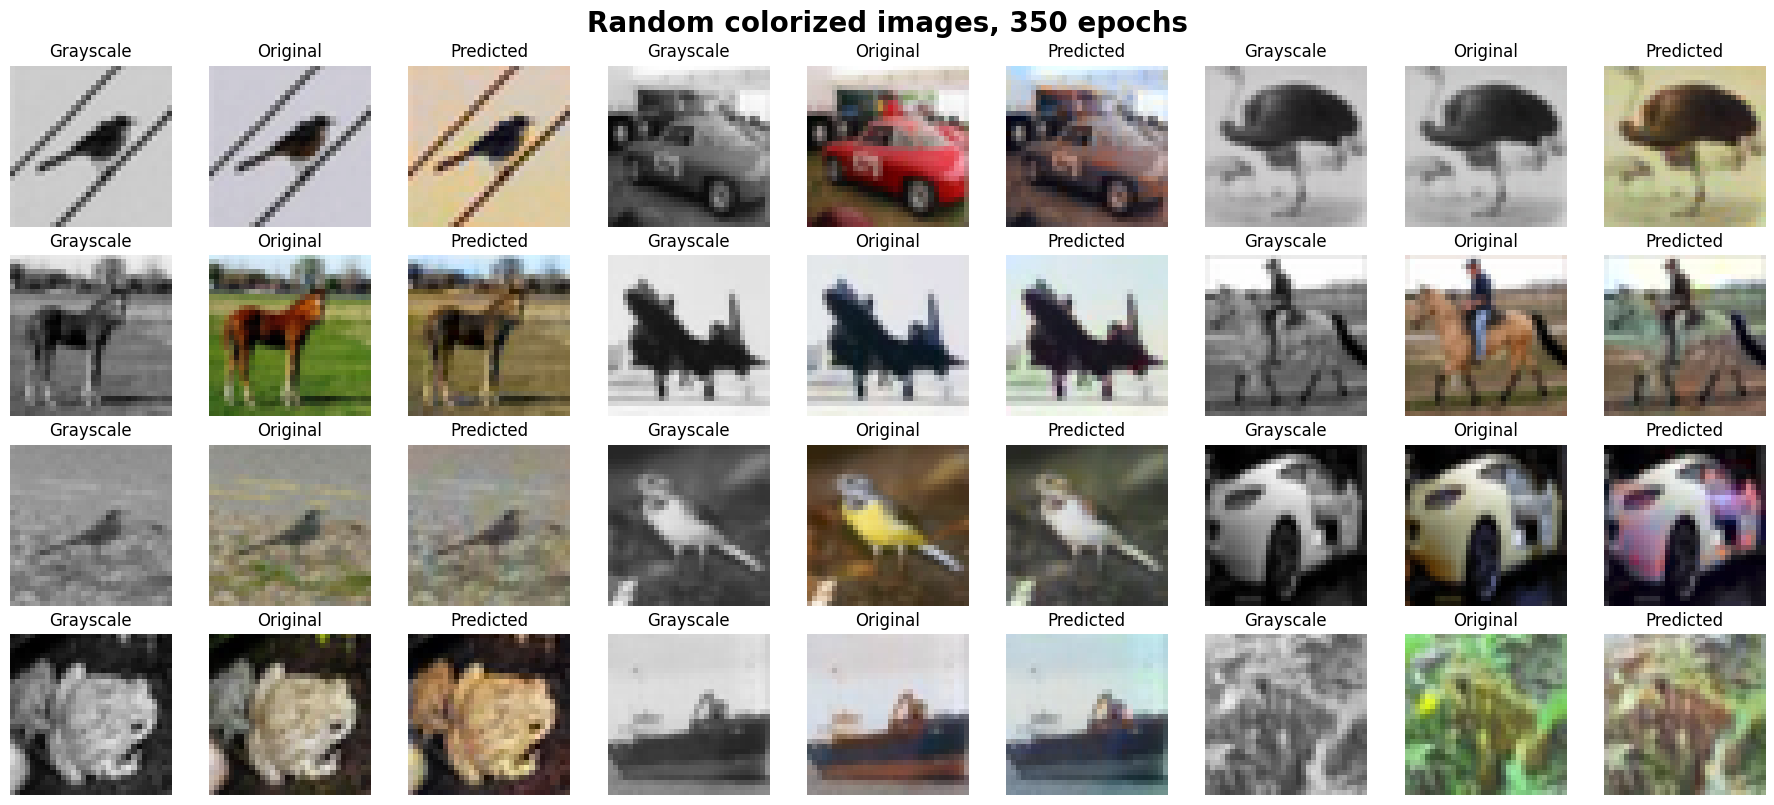

In [ ]:
def plot_test_colorized_images_random(n_samples: int, test_generator: keras.Model) -> None:
    indices = np.random.choice(len(X_test), n_samples, replace=False)
    
    # Generate colorized versions of the randomly selected grayscale images in the test set
    Y_hat = test_generator(X_test[indices])

    num_cols = 9  # Number of columns in the grid (3 triplets per row)
    num_rows = (n_samples + 2) // 3  # Number of rows in the grid
    font_size = 12  # Font size for titles

    # Create a grid of subplots with num_rows rows and num_cols columns
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)  # Adjust spacing between subplots

    # Loop over the grayscale images, original color images, and colorized images
    for i, (x, y, y_hat) in enumerate(zip(X_test[indices], Y_test[indices], Y_hat)):
        row = i // 3
        col = (i % 3) * 3

        # Convert the original color image from Lab to RGB
        orig_lab = np.dstack((x, y * 128))
        orig_rgb = lab2rgb(orig_lab)

        # Convert the grayscale image from Lab to RGB
        grayscale_lab = np.dstack((x, np.zeros((IMAGE_SIZE, IMAGE_SIZE, 2))))
        grayscale_rgb = lab2rgb(grayscale_lab)

        # Convert the colorized image from Lab to RGB
        predicted_lab = np.dstack((x, y_hat * 128))
        predicted_rgb = lab2rgb(predicted_lab)

        # Display the grayscale image in the first column of the current row
        ax: matplotlib.axes.Axes = axes[row, col]  # Get the appropriate axis for the current subplot
        ax.axis('off')
        ax.imshow(grayscale_rgb)
        ax.set_title('Grayscale', fontsize=font_size)

        # Display the original color image in the second column of the current row
        ax = axes[row, col + 1]  # Move to the next column for original RGB
        ax.axis('off')
        ax.imshow(orig_rgb)
        ax.set_title('Original', fontsize=font_size)

        # Display the colorized image in the third column of the current row
        ax = axes[row, col + 2]  # Move to the next column for predicted colorized image
        ax.axis('off')
        ax.imshow(predicted_rgb)
        ax.set_title('Predicted', fontsize=font_size)

    # Hide empty subplots if any
    for ax_row in axes:
        for ax in ax_row:
            if not ax.has_data():
                ax.axis('off')

    plt.suptitle(f'Random colorized images, {EPOCHS} epochs', fontsize=20, fontweight='bold', y=0.99)
    plt.tight_layout(pad=0.5)
    plt.savefig(os.path.join(f"{WORKDIR}/..", f'GAN_{EPOCHS}_test_random.png'))
    plt.show()

plot_test_colorized_images_random(n_samples=12, test_generator=test_generator)